## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [30]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import time

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [52]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [53]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [54]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [55]:
len(fmnist_dataset_test)

10000

In [56]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

Архитектура модели

In [57]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(TinyNeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 512),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.6),    
            nn.Linear(128, 50),
            nn.BatchNorm1d(50),
            nn.ReLU(),    
            nn.Dropout(0.6),
            nn.Linear(50, num_classes),
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

Обучение модели, взято из семинара
https://github.com/girafe-ai/ml-course/blob/master/week0_08_dropout_batchnorm/practice_pytorch_and_dataloaders.ipynb

In [58]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            ### YOUR CODE HERE
            y_pred = model(X_batch)
            loss = loss_func(y_pred, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            ### YOUR CODE HERE
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                ### YOUR CODE HERE
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                ### YOUR CODE HERE
                y_pred = model(X_batch)
                loss = loss_func(y_pred, y_batch)
              

                # compute predictions
                ### YOUR CODE HERE
                ep_val_loss.append(loss.item())
                y_pred = y_pred.max(dim=1)[1] ### YOUR CODE HERE
                ep_val_accuracy.append((y_pred == y_batch).detach().cpu().numpy().mean())

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [59]:
n_epochs = 30
model = TinyNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 4.177s
	  training loss: 2.056346
	validation loss: 1.684829
	validation accuracy: 0.606
Epoch 2 of 30 took 4.214s
	  training loss: 1.733607
	validation loss: 1.470205
	validation accuracy: 0.680
Epoch 3 of 30 took 4.331s
	  training loss: 1.581663
	validation loss: 1.324945
	validation accuracy: 0.707
Epoch 4 of 30 took 4.210s
	  training loss: 1.465245
	validation loss: 1.213296
	validation accuracy: 0.729
Epoch 5 of 30 took 4.223s
	  training loss: 1.373363
	validation loss: 1.120689
	validation accuracy: 0.738
Epoch 6 of 30 took 4.309s
	  training loss: 1.302727
	validation loss: 1.039457
	validation accuracy: 0.748
Epoch 7 of 30 took 4.197s
	  training loss: 1.243164
	validation loss: 0.975760
	validation accuracy: 0.759
Epoch 8 of 30 took 4.196s
	  training loss: 1.190418
	validation loss: 0.915975
	validation accuracy: 0.768
Epoch 9 of 30 took 4.258s
	  training loss: 1.148403
	validation loss: 0.873540
	validation accuracy: 0.770
Epoch 10 of 30 took 4.275s
	

In [60]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

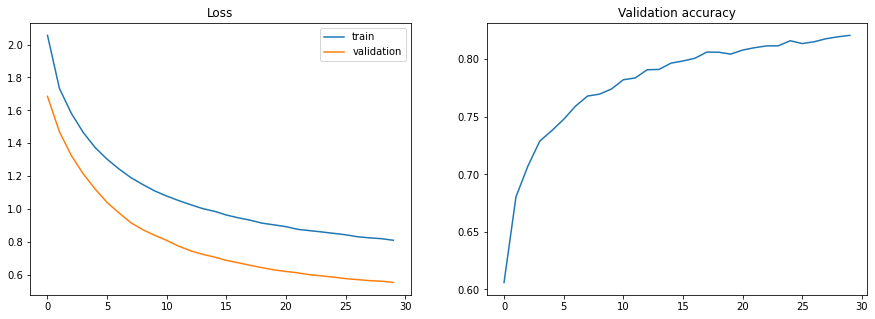

In [61]:
plot_train_process(train_loss, val_loss, val_accuracy)

Мы видим по графикам лосса для выборки обучения и валидации, что ошибка на валидации ниже ошибки на трейне, что значит, что переобучение не наступило еще, более того - не наступило то обучение для модели, которое мы можем выжать из этих данных

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

Убери дропаут и нормализацию, а еще увеличу размер скрытого слоя, чтобы добиться переобучения

In [68]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(OverfittingNeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            # Increase network complexity here (e.g., add more linear layers)
            nn.Linear(input_shape, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.1)
loss_func = nn.CrossEntropyLoss()

In [69]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 10.811s
	  training loss: 2.253219
	validation loss: 1.665705
	validation accuracy: 0.234
Epoch 2 of 30 took 10.702s
	  training loss: 1.345556
	validation loss: 0.893415
	validation accuracy: 0.642
Epoch 3 of 30 took 11.025s
	  training loss: 0.773663
	validation loss: 0.610012
	validation accuracy: 0.759
Epoch 4 of 30 took 12.330s
	  training loss: 0.550772
	validation loss: 0.492556
	validation accuracy: 0.819
Epoch 5 of 30 took 11.969s
	  training loss: 0.817646
	validation loss: 0.665418
	validation accuracy: 0.766
Epoch 6 of 30 took 11.860s
	  training loss: 0.528280
	validation loss: 0.669902
	validation accuracy: 0.760
Epoch 7 of 30 took 11.936s
	  training loss: 0.439833
	validation loss: 0.442778
	validation accuracy: 0.838
Epoch 8 of 30 took 11.676s
	  training loss: 0.391046
	validation loss: 0.428997
	validation accuracy: 0.852
Epoch 9 of 30 took 11.423s
	  training loss: 0.398313
	validation loss: 0.372702
	validation accuracy: 0.867
Epoch 10 of 30 took

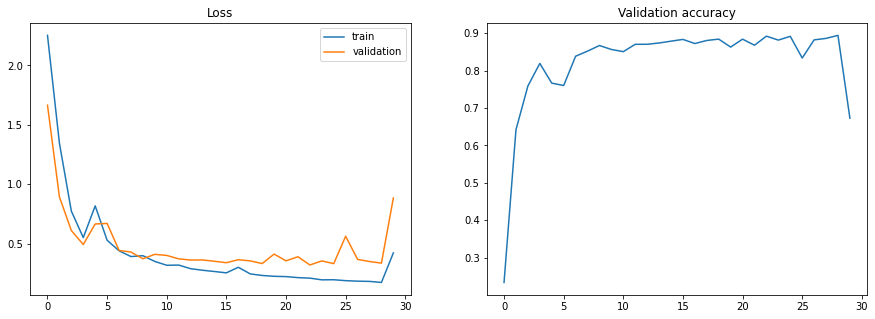

In [70]:
plot_train_process(train_loss, val_loss, val_accuracy)

Основной совет для переобучения - застакать больше слоев, убрать регуляризацию и сделать большой шаг обучения.
По графику лосса на трейне и тесте мы видим, что случилось переобучение, так как ошибка на валидации стала расти - около 8 эпохи кривые стали расходиться(в этот момент и случилось переобучение)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

Добавим в архитектуру сети нормализацию и достаточной высокий дропаут, чтобы убрать переобучение

In [74]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(FixedNeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            # Apply regularization techniques (e.g., Dropout, Batch Normalization) to reduce overfitting
            nn.Linear(input_shape, 2048),         
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),         
            nn.ReLU(),
            nn.Dropout(0.5),  
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),  
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),  
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),  
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

model = FixedNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

In [75]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 11.208s
	  training loss: 1.972129
	validation loss: 1.382105
	validation accuracy: 0.589
Epoch 2 of 30 took 11.152s
	  training loss: 1.239933
	validation loss: 0.839363
	validation accuracy: 0.696
Epoch 3 of 30 took 11.207s
	  training loss: 0.921032
	validation loss: 0.672703
	validation accuracy: 0.753
Epoch 4 of 30 took 11.284s
	  training loss: 0.779526
	validation loss: 0.596036
	validation accuracy: 0.761
Epoch 5 of 30 took 11.401s
	  training loss: 0.694157
	validation loss: 0.541359
	validation accuracy: 0.795
Epoch 6 of 30 took 11.309s
	  training loss: 0.638054
	validation loss: 0.504515
	validation accuracy: 0.810
Epoch 7 of 30 took 11.432s
	  training loss: 0.595259
	validation loss: 0.476577
	validation accuracy: 0.829
Epoch 8 of 30 took 11.456s
	  training loss: 0.560277
	validation loss: 0.458639
	validation accuracy: 0.837
Epoch 9 of 30 took 11.339s
	  training loss: 0.533509
	validation loss: 0.442089
	validation accuracy: 0.846
Epoch 10 of 30 took

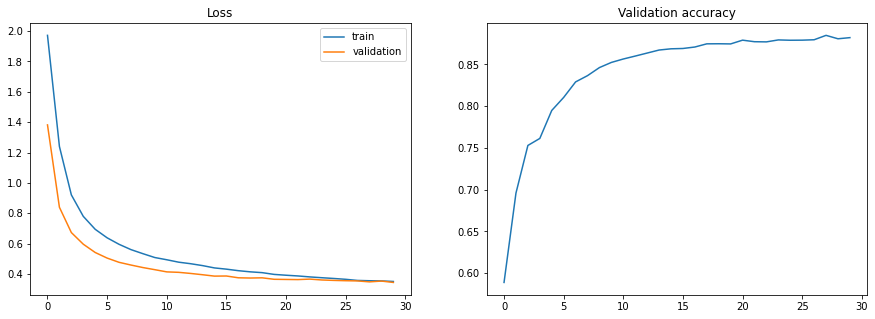

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

Удалось подобрать такую архитектуру, при которой  модель на трейне и тесте дает одинаковые результаты, стабилизируясь на точность 0.88 (видимо, это предел точности для полносязной архитектуры, д) - это значит, что мы смогли извлечь информацию из данных в обучении, но при этом не даем модели переобучиться. Из трех моделей в данной работе эта самая оптимальная и результат точности на валидации это подтверждает.

### Conclusions:
В данной работе мы решали задачу классификации на 10 классов для изображений с помощью полносвязной архитектуры сети с использованием таких приемов как батч-нормализация, дропаут и нелинейность, а также варьируя шаг обучения

1) батч-нормализация нужна, если у нас много слоев для стабилизации вычислений градиента и для ускорения сходимости (но у нас слоев немного, поэтому существенного вляиния на качество я не заметила)

2) Дропаут - средство борьбы с переуобучением, работает эффективно, я убирала половину связей случайным образом после каждого слоя для того, чтобы модель не запоминала данные в трейне, а старалась выявить ообщающие закономерности

3) Шаг обучения в данной работе существенно влиял на сходимость. Во 2 части, где нужно было добиться переобчения когда я поставила шаг в 0.001 модель вообще перестала учиться, а при 0.1 случилось очевидное переобучение.

4) Пробовала другие виды нелинейности, если честно, особой разницы не заметила


